<a href="https://colab.research.google.com/github/PrettyCharity/Kaggle_competitions/blob/main/House_Prices_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#########################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

from google.colab import drive
drive.mount('/content/drive/')
#########################################################
## Do not forget to add index_col = 0
train = pd.read_csv('/content/drive/MyDrive/Data/Ohio/train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/Data/Ohio/test.csv', index_col=0)

# Concatenate the train and test data
X = pd.concat([train.drop('SalePrice', axis=1), test], axis=0)
y = train[['SalePrice']]

# Isolate numeric and categorical columns
numeric_ = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass'] # MSSubClass is nominal

###
disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)
###

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive/


# Univariate Analysis
### Numeric Features
For numerical features, we are always concerned about the **distribution** of these features, including the **statistical characteristics** of these columns e.g mean, median, mode. Hence we will usually use **Distribution plot** to visualize their data distribution. **Boxplots** are also commonly used to unearth the statistical characteristics of each feature. More often than not, we use it to look for any outliers that we might need to filter out later on during the preprocessing step.


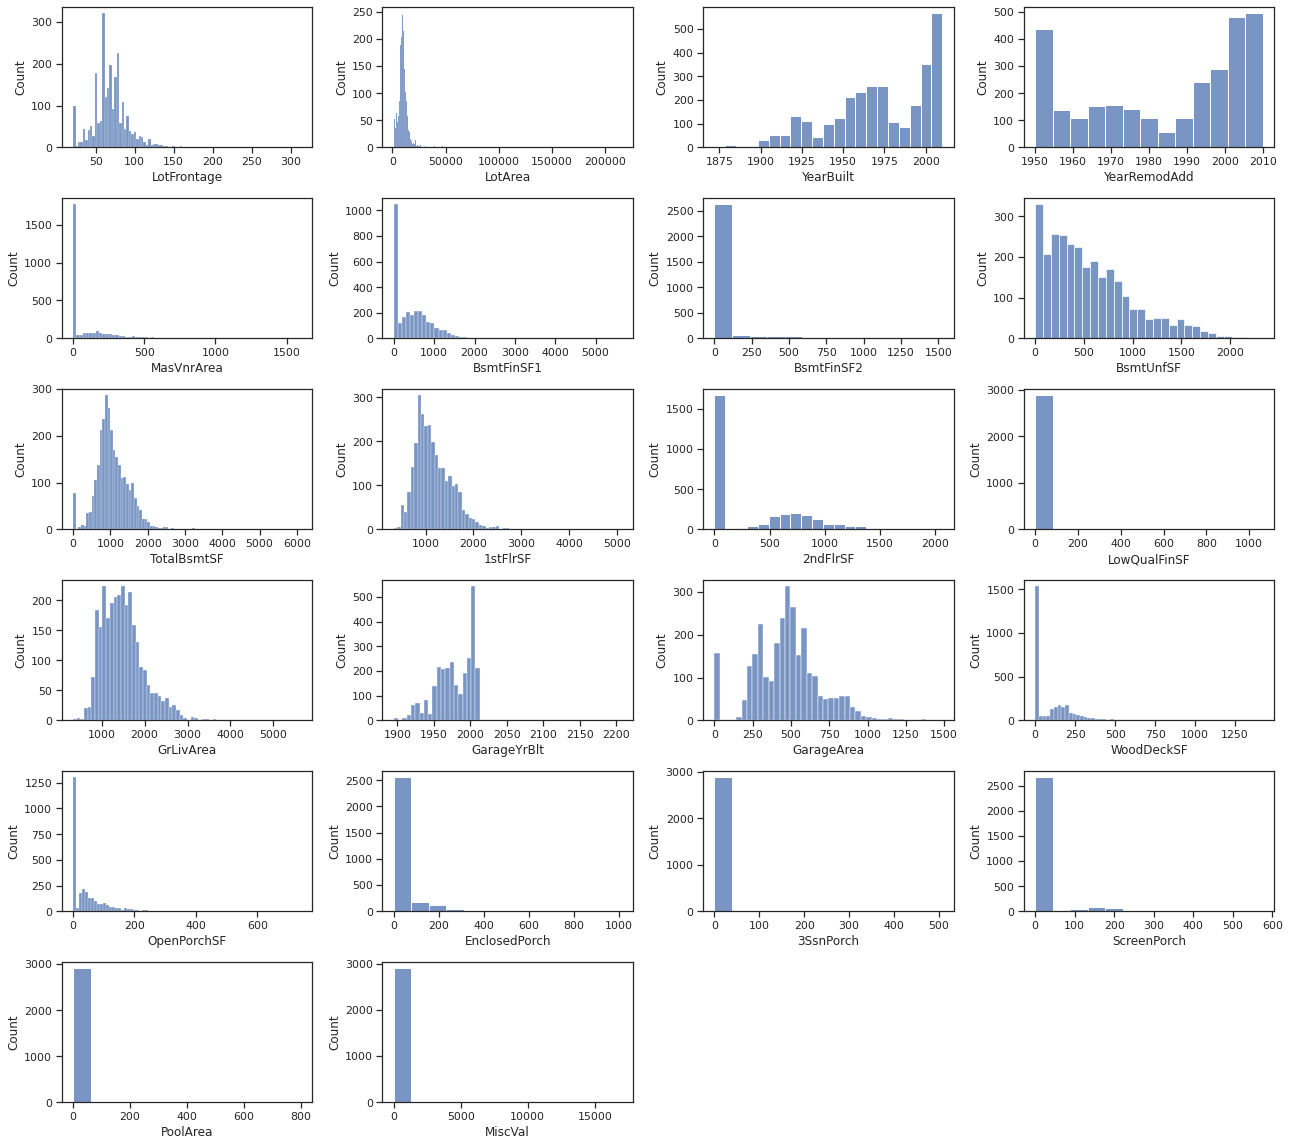

In [ ]:
fig = plt.figure(figsize=(18, 16))
for index, col in enumerate(cont_num_var):
  plt.subplot(6, 4, index+1)
  sns.histplot(numeric_.loc[:, col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

Some of the Variables with mostly 1 value as seen from the plots above:



*   BsmtFinSF2
*   LowQualFinSF
*   EnclosedPorch
*   3SsnPorch
*   ScreenPorch
*   PoolArea
*   MiscVal

All these features are highly skewed, with mostly 0s. Having alot of 0s in the distribution doesn't really add information for predicting Housing Price. Hence, we will remove them during our preprocessing step.

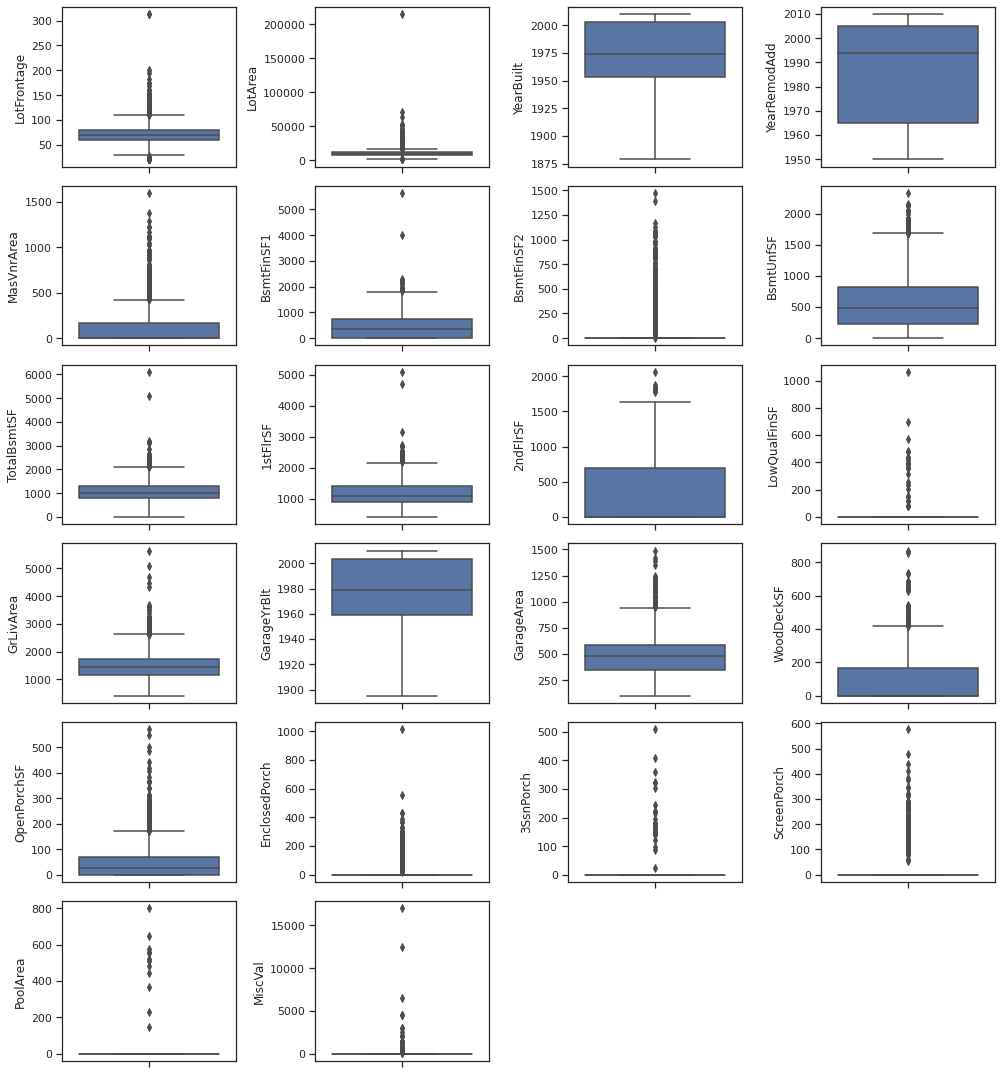

In [ ]:
fig = plt.figure(figsize=(14, 15))
for index, col in enumerate(cont_num_var):
  plt.subplot(6, 4, index+1)
  sns.boxplot(y=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

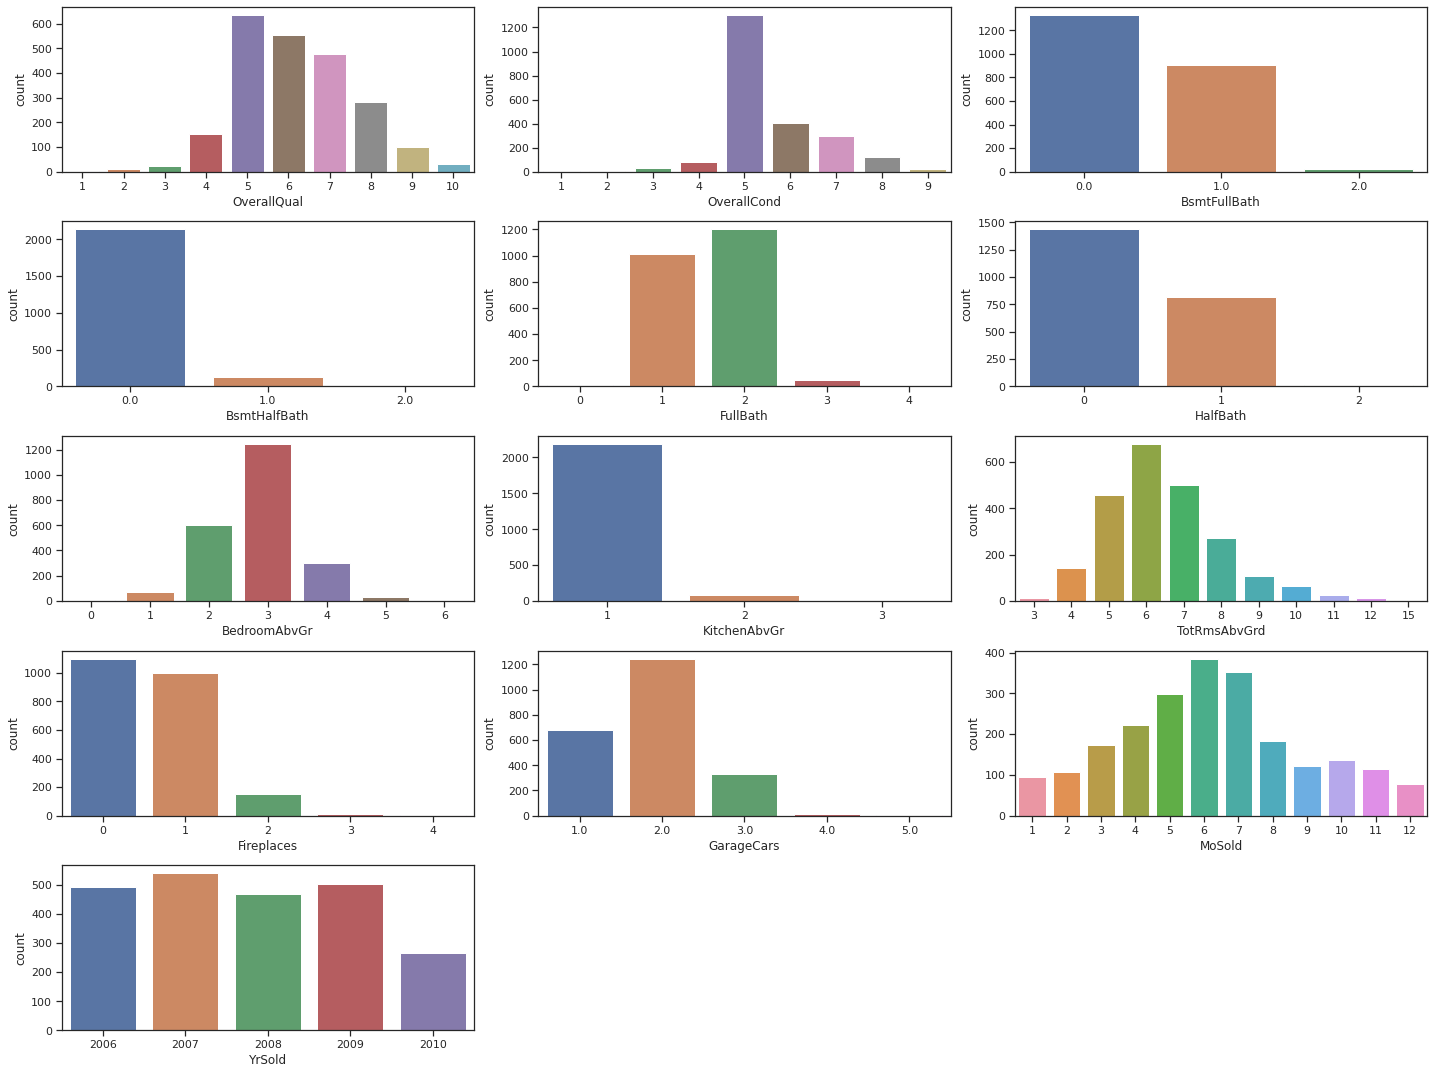

In [ ]:
fig = plt.figure(figsize=(20, 15))
for index, col in enumerate(disc_num_var):
  plt.subplot(5, 3, index+1)
  sns.countplot(x=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

### Categorical Features
In the case of categorical features, we will often use countplots to visualize the count of each distinct value within each features. We can see that some categorical features like **Utilities**, **Condition2** consist of mainly just one value, which does not add any useful information. Thus, we will also remove them later on.


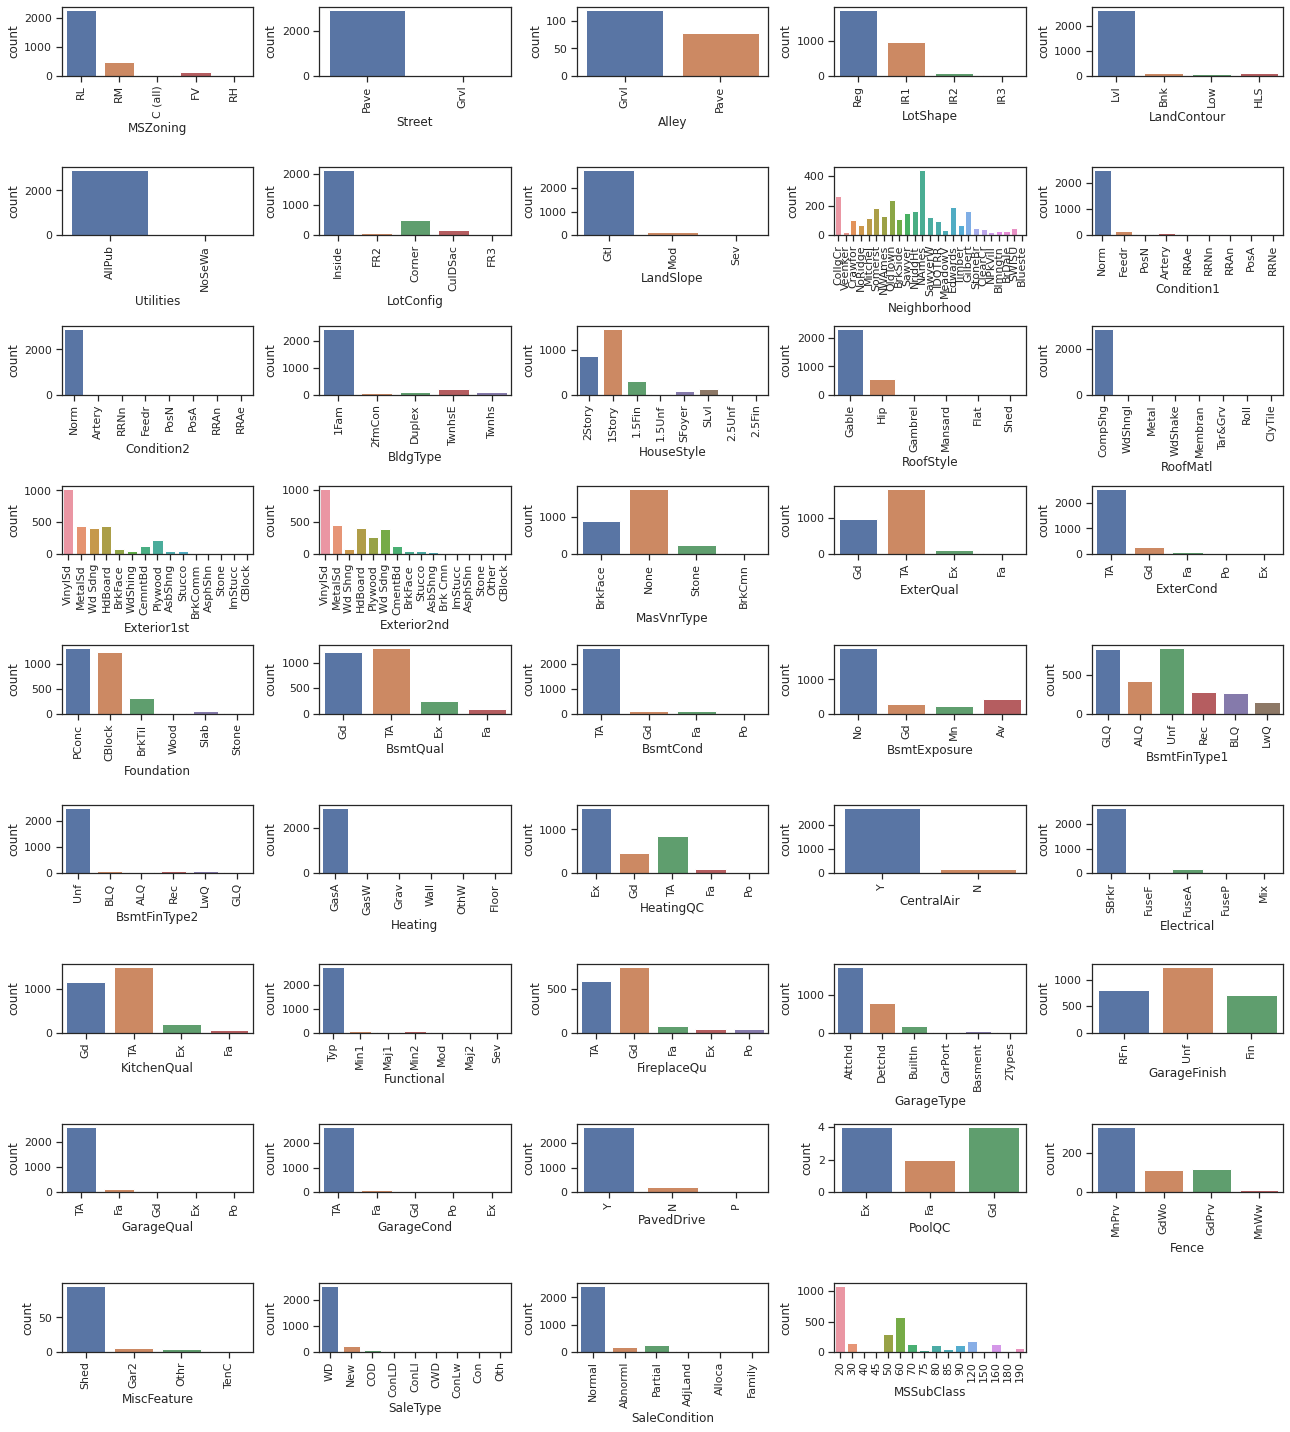

In [ ]:
fig = plt.figure(figsize=(18, 20))
for index in range(len(cat_train.columns)):
  plt.subplot(9, 5, index+1)
  sns.countplot(x=cat_train.iloc[:, index], data=cat_train.dropna())
  plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

### Bi-variate Analysis

Bi-variate analysis looks at 2 different features to identify any possible relationship or distinctive patterns between the 2 features. One of the commonly used technique is through the **Correlation Matrix**. Correlation matrix is an effective tool to uncover linear relationship (Correlation) between any 2 continuous features. Correlation not only allow us to determine which features are important to Saleprice, but also as a mean to investigate any **multicollinearity** between our independent predictors.

Multicollinearity happens when 2 or more independent variables are highly correlated with one another. In such situation, it causes precision loss in our regression coefficients, affecting our ability to identify the most important features that are most useful to our model

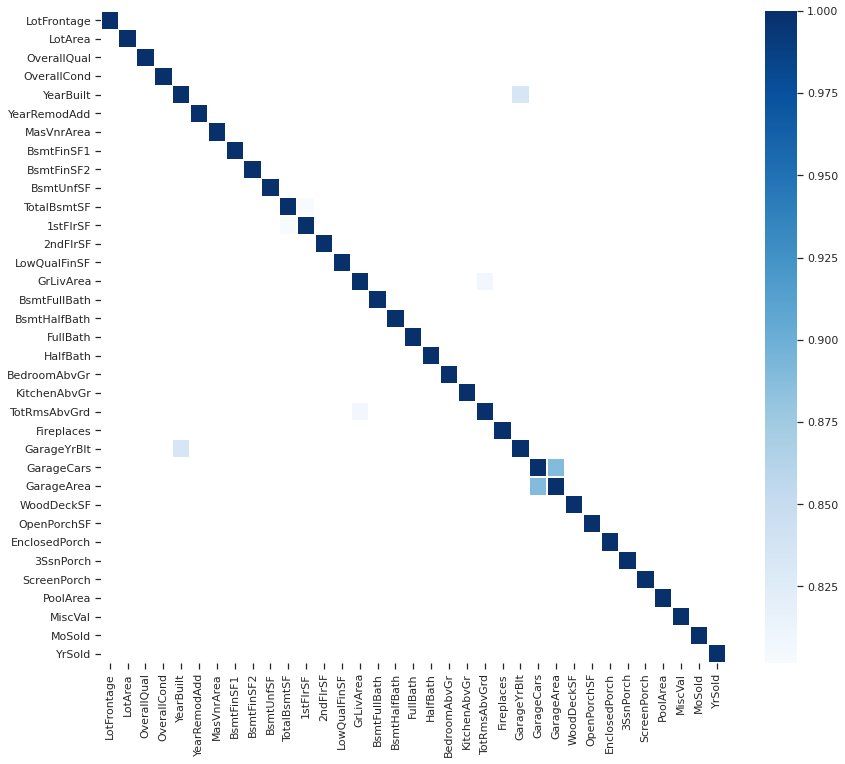

In [ ]:
plt.figure(figsize=(14, 12))
correlation = numeric_.corr()
sns.heatmap(correlation, mask = correlation < 0.8, linewidth = 0.5, cmap='Blues')

**Highly Correlated variables:**

*   GarageYrBlt and YearBuilt
*   TotRmsAbvGrd and GrLivArea
*   1stFlrSF and TotalBsmtSF
*   GarageArea and GarageCars

From the correlation matrix we have identified the above variables which are highly correlated with each other. This finding will guide us in our preprocessing steps later on as we aim to remove highly correlated features to avoid performance loss in our model

**Identifying relationship between Numerical Predictor and Target (SalePrice)**

Below, we sorted the strength of linear relationship between Saleprice and other features. OverallQual and GrLivArea has the strongest linear relationship with SalePrice. Hence, these 2 features will be important factor in predicting Housing Price

In [ ]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Scatterplot

Using scatterplot can also help us to identify potential linear relationship between Numerical features. Although scatterplot does not provide quantitative evidence on the strength of linear relationship between our features, it is useful in helping us to visualize any sort of relationship that correlation matrix could not calculate. E.g Quadratic, Exponential relationships.

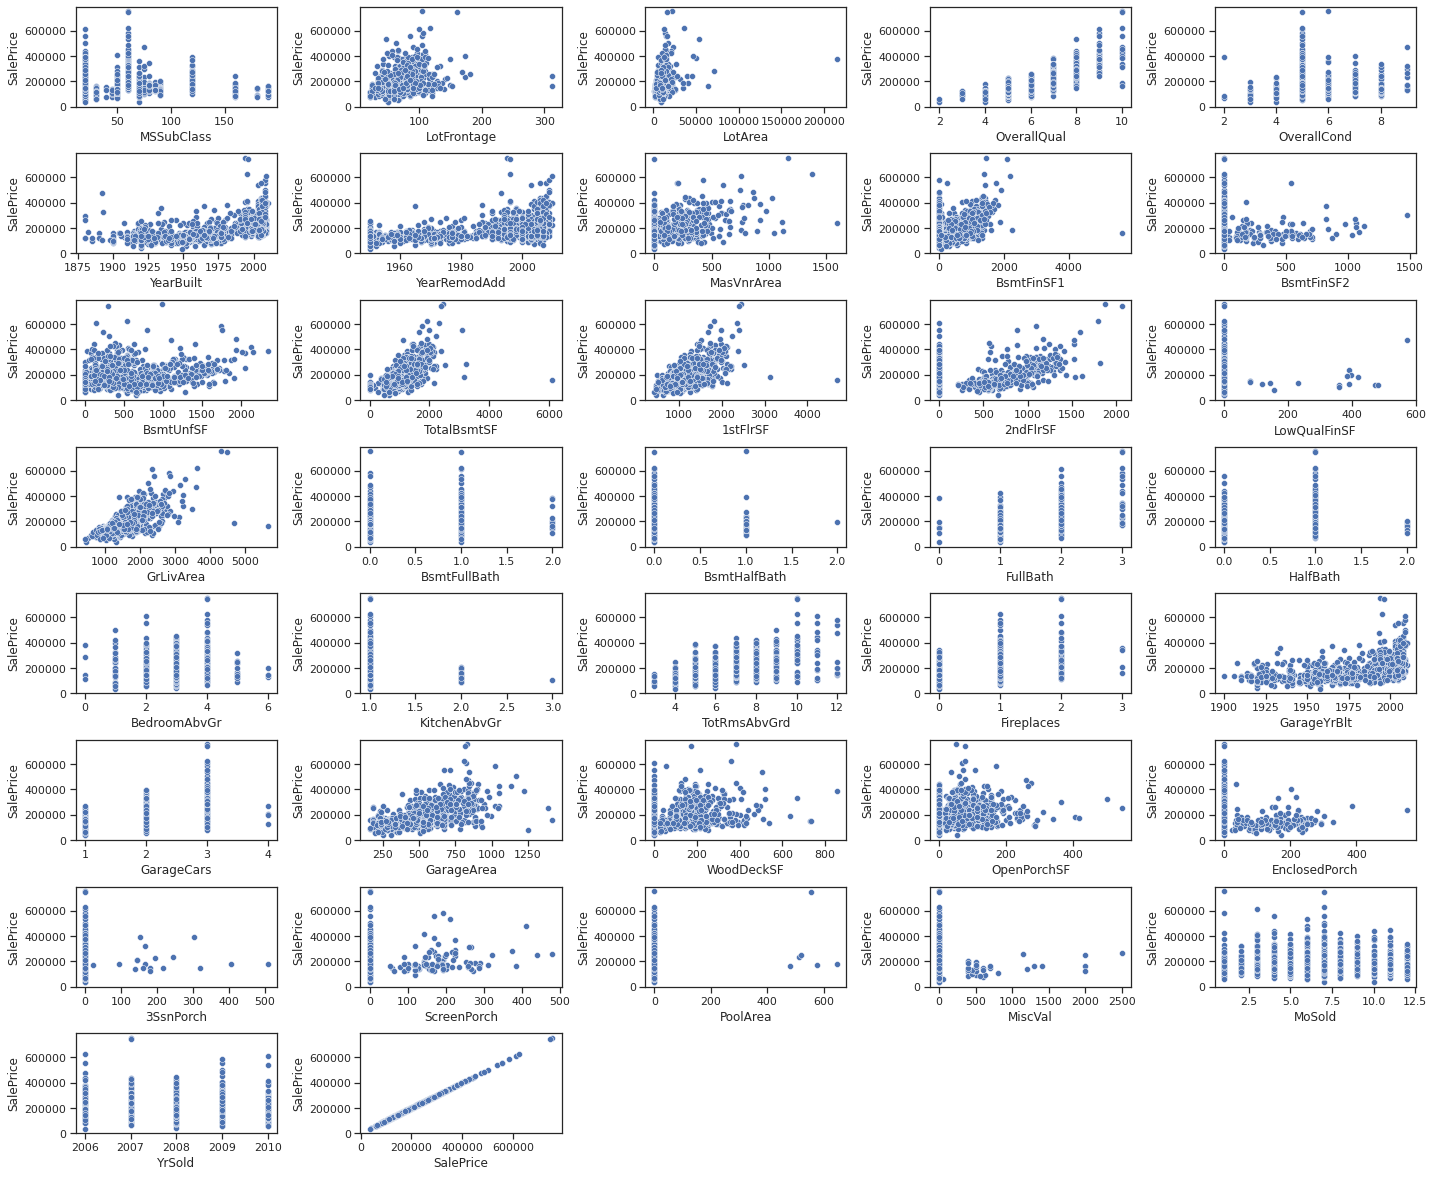

In [ ]:
fig = plt.figure(figsize=(20, 20))
for index in range(len(numeric_train.columns)):
  plt.subplot(10, 5, index+1)
  sns.scatterplot(x=numeric_train.iloc[:, index], y='SalePrice', data=numeric_train.dropna())
fig.tight_layout(pad=1.0)

# **DATA PROCESSING**


1.   Removing Redundant Features
2.   Dealing with Outliers
3.   Filling in missing values






In [ ]:
# Removing Redundant Features

# Feautures with multicollinearity

X.drop(['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars'], axis=1, inplace=True)


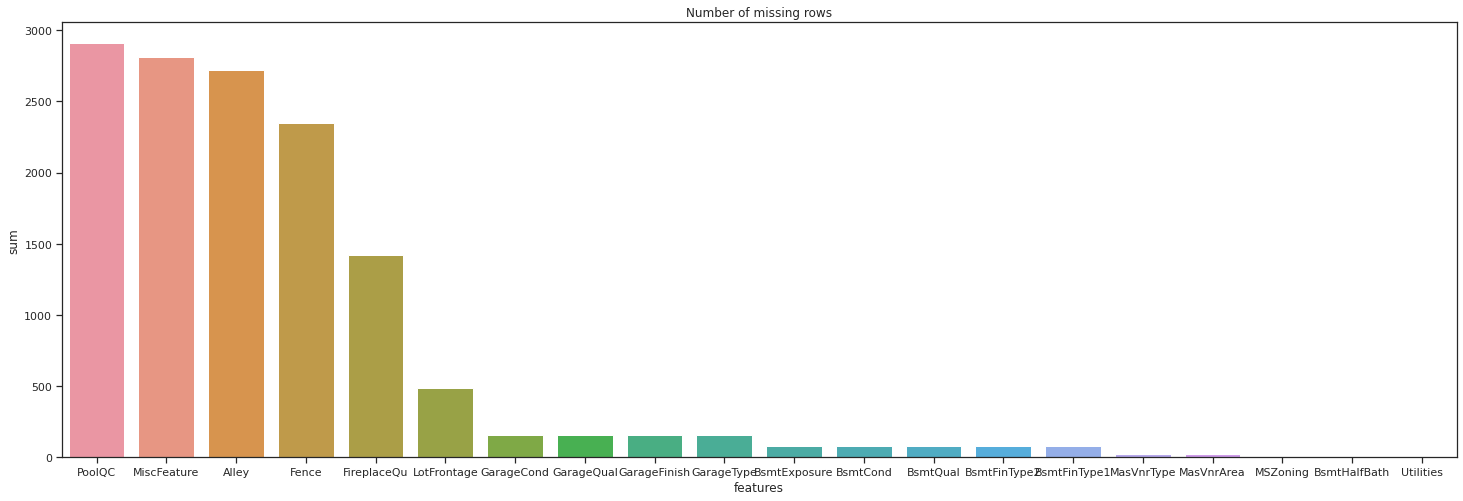

In [ ]:
# Features with alot of missing values

plt.figure(figsize=(25, 8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'], ascending=False).head(20).reset_index()
missing_count.columns = ['features', 'sum']
sns.barplot(x='features', y='sum', data = missing_count)

In [ ]:
X.drop(['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

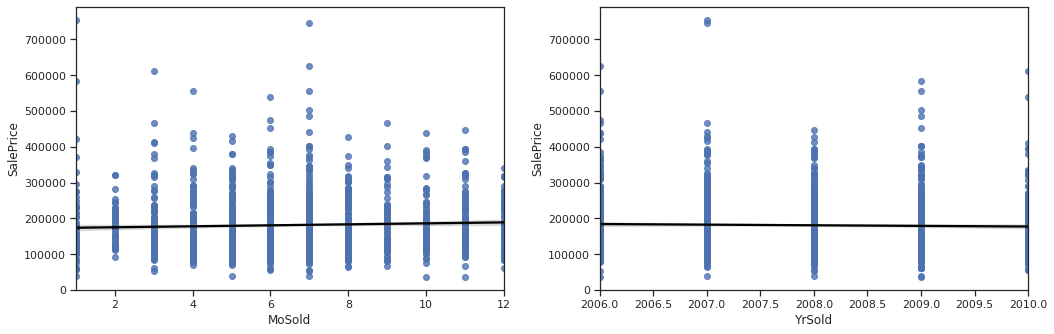

In [ ]:
# Useless features in predicting SalePrice

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1], line_kws={'color':'black'})
fig.tight_layout(pad=2.0)

In [ ]:
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False).tail(10)


,SalePrice
3SsnPorch,0.044584
BsmtFinSF2,-0.011378
BsmtHalfBath,-0.016844
MiscVal,-0.021190
LowQualFinSF,-0.025606
YrSold,-0.028923
OverallCond,-0.077856
MSSubClass,-0.084284
EnclosedPorch,-0.128578
KitchenAbvGr,-0.135907


In [ ]:
X.drop(['MoSold', 'YrSold'], axis=1, inplace=True)

### Removing features that have mostly just 1 value


Earlier during our Univariate analysis, we found that some features mostly consist of just a single value or 0s, which is not useful to us. Therefore, we set a user defined threshold at **96%**. If a column has more than 96% of the same value, we will render the features to be useless and remove it, since there isnt much information we can extract from

In [ ]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
  counts = X[i].value_counts()
  zeros = counts.iloc[0]
  if zeros / len(X)*100 > 96:
    overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)

In [ ]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
  counts = X[i].value_counts()
  zeros = counts.iloc[0]
  if zeros / len(X)*100 > 96:
    overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

In [ ]:
print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


### Dealing with Outliers

Removing outliers will prevent our models performance from being affected by extreme values.

From our boxplot earlier, we have pinpointed the following features with extreme outliers:

*   LotFrontage
*   LotArea
*   BsmtFinSF1
*   TotalBsmtSF
*   GrLivArea

We will remove the outliers based on certain threshold value.

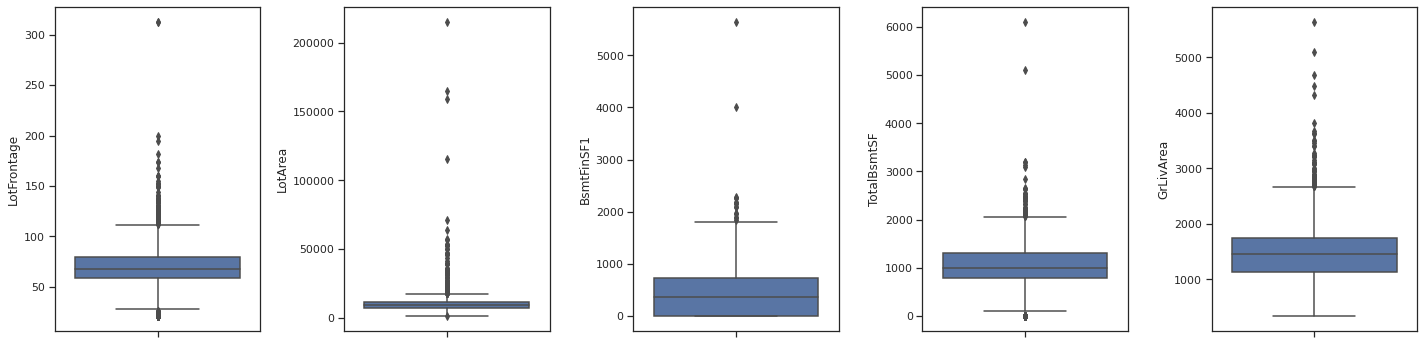

In [ ]:
out_col = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea']
fig = plt.figure(figsize=(20, 5))
for index, col in enumerate(out_col):
  plt.subplot(1, 5, index+1)
  sns.boxplot(y=col, data=X)
fig.tight_layout(pad=1.5)

In [ ]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

X.shape

(2919, 61)

### Filling Missing Values

Our machine learning model is unable to deal with missing values, thus we need to deal with them based on our understanding of the features. These missing values are denoted **NAN** as we have seen earlier during our data exploration.

In [ ]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'], ascending=False).head(15)

,sum
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageCond,159
GarageQual,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81


### Ordinal Features

We will replace the ordinal missing values with **NA**, which will be mapped later on when we encode them into an ordered arrangement

In [ ]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']
X[cat] = X[cat].fillna('NA')

### Categorical Features

We will replace the missing value of our categorical features with the most frequent occurrence (*mode*) of the individual features.

In [ ]:
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

### Numerical features

For *Numerical Features*, the common approach will be to replace the missing value with the mean of the feature distribution.

However, certain features like *LotFrontage* and *GarageArea* have wide variance in their distribution. Taking mean values across Neighborhoods, we will see that the mean varies alot from just taking the mean value of these individual column, since each neighborhood have different LotFrontage and GarageArea mean value. Hence, i decided to group these features by Neighborhoods to impute the respective mean values.

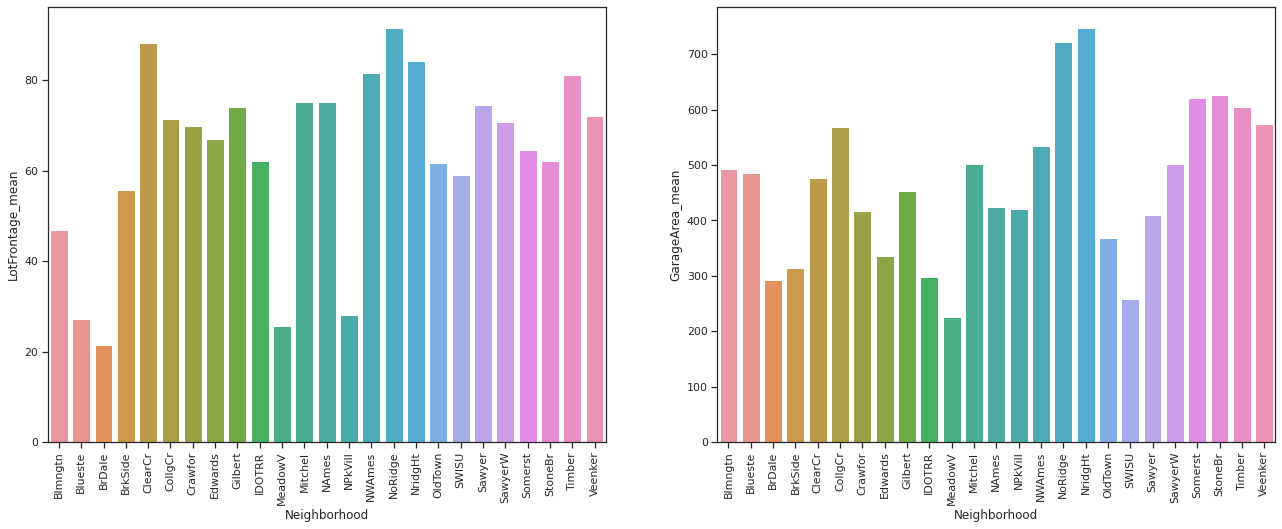

In [ ]:
# Numerical Features

neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes[0].tick_params(axis = 'x', rotation = 90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis = 'x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [ ]:
# for correlated relationship
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont].fillna(X[cont].mean())


### Changing Data Type

Since **MSSubClass** is an integer column based on some mapped values in string notation, we change its data type to string value instead.

In [ ]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

### Mapping Ordinal Features

There are some columns which are ordinal by nature, which represents the quality or condition of certain housing features. In this case, we will map the respective strings to a value. The better the quality, the higher the value

In [ ]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [ ]:
ord_col = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'FireplaceQu']
for col in ord_col:
  X[col] = X[col].map(ordinal_map)

fin_col = ['BsmtFinType1', 'BsmtFinType2']
for col in fin_col:
  X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)
X['Fence'] = X['Fence'].map(fence_map)

# Feature Engineering 

Feature Engineering is a technique by which we create new features that could potentially aid in predicting our target variable, which in this case, is *SalePrice*. In this notebook, we will create additional features based on our **Domain Knowledge** of the housing features.

Based on the current feature we have, the first additional featuire we can add would be **TotalLot**, which sums up both the *LotFrontage* and *LotArea* to identify the total area of land available as lot. We can also calculate the total number of surface area of the house, **TotalSF** by adding the area from basement and 2nd floor. **TotalBath** can also be used to tell us in total how many bathrooms are there in the house. We can also add all the different types of porches around the house and generalise into a total porch area, **TotalPorch**.

*   TotalLot = LotFrontage + LotArea
*   TotalSF = TotalBsmtSF + 2ndFlrSF
*   TotalBath = FullBath + HalfBath
*   TotalPorch = OpenPorchSF + EnclosedPorch + ScreenPorch
*   TotalBsmtFin = BsmtFinSF1 + BsmtFinSF2


In [ ]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

### Binary Columns

We also include simple feature engineering by creating binary columns for some features that can indicate the **presence (1)** / **absence (0)** of some features of the house.

In [ ]:
colum = ['MasVnrArea', 'TotalBsmtFin', 'TotalBsmtSF', '2ndFlrSF', 'WoodDeckSF', 'TotalPorch']

for col in colum:
  col_name = col+'_bin'
  X[col_name] = X[col].apply(lambda x: 1 if x > 0 else 0)

### Converting Categorical to Numerical

Lastly, because machine learning only learns from data that is numerical in nature, we will convert the remaining categorical columns into one-hot features using the *get_dummies()* method into numerical columns that is suitable for feeding into our machine learning algorithm.

In [ ]:
X = pd.get_dummies(X)

Text(0.5, 1.0, 'Before Transformation of SalePrice')

<Figure size 720x432 with 0 Axes>

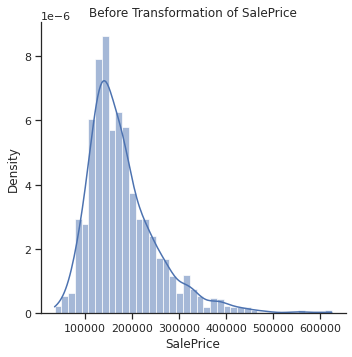

In [ ]:
# SalePrice Distribution

plt.figure(figsize=(10,6))
sns.displot(train['SalePrice'], stat = 'density', kde = True)
plt.title("Before Transformation of SalePrice")

Distribution is skewed to the right, where the tail on the curve’s right-hand side is longer than the tail on the left-hand side, and the mean is greater than the mode. This situation is also called *positive skewness*.

Having a skewed target will affect the overall performance of our machine learning model, thus, one way to alleviate will be to using **log transformation **on skewed target, in our case, the SalePrice to reduce the skewness of the distribution.

Text(0.5, 1.0, 'After transformation of SalePrice')

<Figure size 720x432 with 0 Axes>

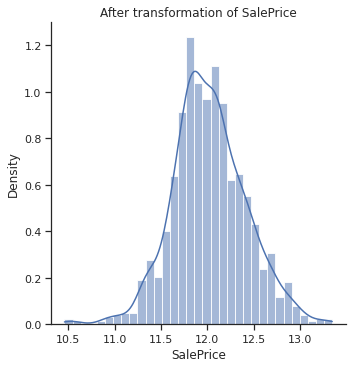

In [ ]:
plt.figure(figsize=(10,6))
sns.displot(np.log(train['SalePrice']), stat = 'density', kde = True)
plt.title('After transformation of SalePrice')

In [ ]:
y["SalePrice"] = np.log(y['SalePrice'])

# MODELLING

This section will consist of scaling the data for better optimization in our training, and also introducing the varieties of ensembling methods that are used in this notebook for predicting the Housing price. We also try out hyperparameter tuning briefly.

In [ ]:
# Split into train-validation set
x = X.loc[train.index]
y = y.loc[train.index]
test = X.loc[test.index]

print(f'Shape of X: {X.shape}, of x: {x.shape}, of y: {y.shape} and of test: {test.shape}.')

Shape of X: (2919, 223), of x: (1451, 223), of y: (1451, 1) and of test: (1459, 223).


### Scaling of Data

**RobustScaler** is a transformation technique that removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It is also robust to outliers, which makes it ideal for data where there are too many outliers that will drastically reduce the number of training data.

In [ ]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2021)

### Ensembling Models

Ensembling methods are meta-algorithms which involves combining several machine learning models into one predictive model, aim at decreasing variance(reduce overfitting) and improving bias(improve accuracy).

The 3 main ensembling methods are **Bagging**, **Boosting** and **Stacking**.

In this notebook, we will focus mainly on **Boosting**, which is what we will be using for our prediction.

**Boosting** works on a class of weak learners, improving them into strong learners. It is being improved sequentially where the misclassified instances will be given more weights so that during the subsequent training, the learner will place more emphasis in correcting the previously misclassfied instance, less so on the already correctly identified instances. Over time, the eventual learner will possess the ability to predict accurately as a result of learning from past mistakes

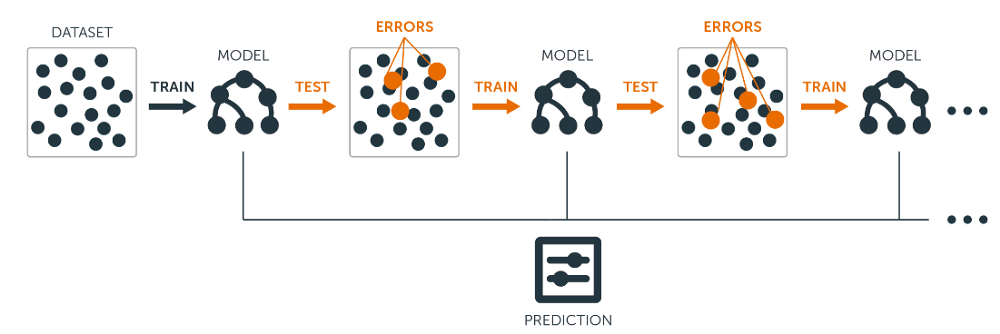

In [ ]:
!pip install catboost

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

### XGBoost

Extreme Gradient Boost (XGB) is a boosting algorithm that uses the gradient boosting framework; where gradient descent algorithm is employed to minimize the errors in the sequential model. It improves on the gradient boosting framework with faster execution speed and improved performance.

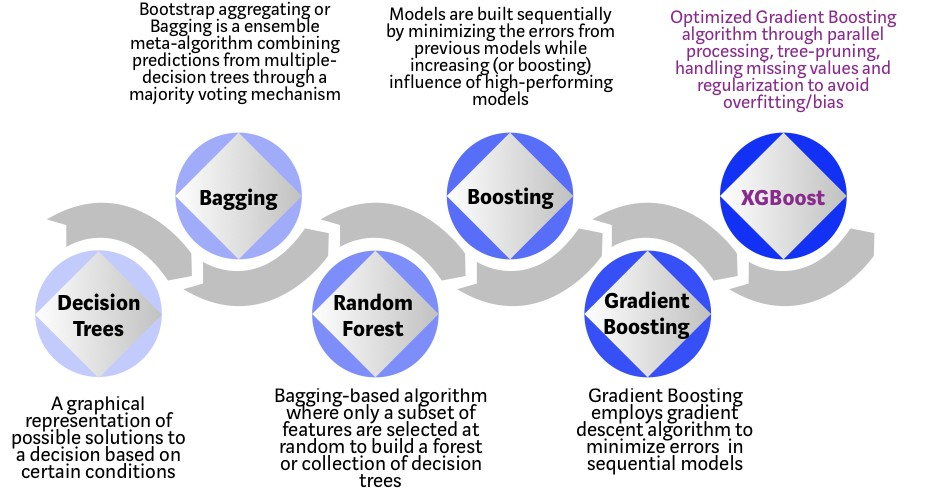

In [ ]:
'''
Find out more on the XGBRegressor implementation and parameters at 
https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
'''

# xgb = XGBRegressor(booster='gbtree', learning_rate=0.3, n_estimators=3460,
#                     max_depth=6, min_child_weight=1, subsample=1,
#                     gamma=0, reg_alpha = 0.001, colsample_bytree=0.7,
#                     objective='reg:squarederror', reg_lambda = 0.001,
#                     scale_pos_weight=1, seed=2020)

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

In [ ]:
# XGBoost HyperParameter Tuning

from sklearn.model_selection import RandomizedSearchCV

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                             n_iter = 100, scoring = 'neg_root_mean_squared_error',
                             cv = 5)

xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)

### LightGBM

LightBGM is another gradient boosting framework developed by Microsoft that is based on decision tree algorithm, designed to be efficient and distributed. Some of the advantages of implementing LightBGM compared to other boosting frameworks include:

1.   Faster training speed and higher efficiency (use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure)
2.   Lower memory usage (Replaces continuous values to discrete bins which result in lower memory usage)
3.   Better accuracy
4.   Support of parallel and GPU learning
5.   Capable of handling large-scale data (capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST)

LightGBM splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. This leaf-wise algorithm reduces more loss than the level-wise algorithm, hence resulting in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.

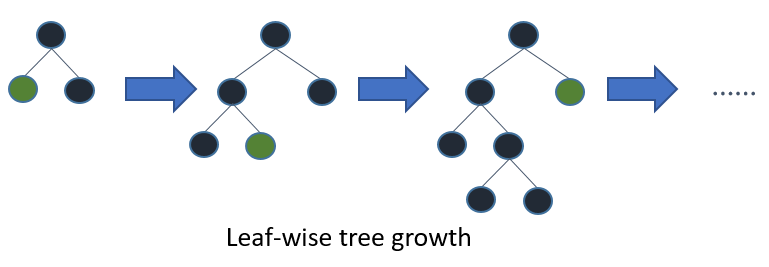

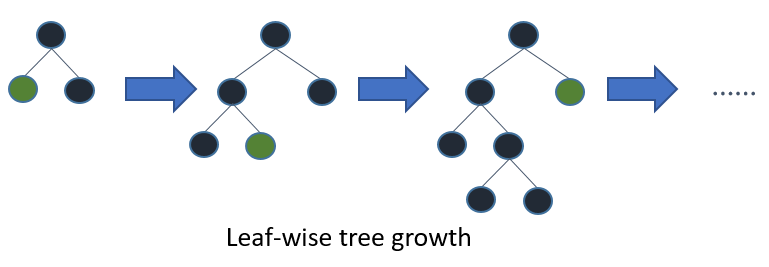

In [ ]:
"""
Learn more avout LightBGM parameters at 
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
"""

lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=-1,
                   lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
                   n_estimators=100, max_bin=200, min_child_samples=20, 
                   bagging_fraction=0.75, bagging_freq=5,
                   bagging_seed=7, feature_fraction=0.8,
                   feature_fraction_seed=7, verbose=-1)

In [ ]:
# LightBGM HyperParameter Tuning

param_lst = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
lightgbm_search = lightgbm.fit(X_train, y_train)

# LightBGM with tuned hyperparameters
best_param = lightgbm_search.best_params_
lgbm = LGBMRegressor(**best_param)

### Catboost

Catboost is another alternative gradient boosting framework developed by Yandex. The word "Catboost" is derived from two words; "Category" and "Boosting". This means that Catboost itself can deal with categorical features which usually has to be converted to numerical encodings in order to feed into traditional gradient boost frameworks and machine learning models.

The 2 critical features in Catboost algorithm is the use of **ordered boosting** and **innovative algorithm** for processing categorical features, which fight the prediction shift caused by a special kind of target leakage present in all existing implementations of gradient boosting algorithms.

Find out more [here](https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2).

In [ ]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

In [ ]:
# CatBoost Hyperparameter Tuning

param_lst = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}

catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

catboost_search = catboost.fit(X_train, y_train)

# CatBoost with tuned hyperparameters
best_param = catboost_search.best_params_
cb = CatBoostRegressor(logging_level='Silent', **best_param)

### Training and Evaluation


---



In [ ]:
def mean_cross_val(model, X, y):
  score = cross_val_score(model, X, y, cv=5)
  mean = score.mean()
  return mean

cb.fit(X_train, y_train)
preds = cb.predict(X_val)
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, x, y)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, x, y)

lgbm.fit(X_train, y_train)
preds = lgbm.predict(X_val)
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, x, y)

In [ ]:
model_performances = pd.DataFrame({
    "Model" : ["XGBoost", "LGBM", "CatBoost"],
    "CV(5)" : [str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
      Model  CV(5)    MAE   RMSE  Score
0   XGBoost  0.909  0.081  0.135  0.899
1      LGBM  0.910  0.083  0.136  0.896
2  CatBoost  -543.  0.082  0.133  -508.


### Blending

Blending is a technique that give different weightage to different algorithms that will affect their influence of the predictions. Such techniques can help to improve performance since it uses a variety of models as predictors. I have randomly chosen the weights for each models in this case, however, you can improve on this by futher tuning the weightage to be given to each model to achieve a better accuracy!

In [ ]:
 def blend_models_predict(X, b, c, d):
        return ((b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X)))

In [ ]:
pred = np.array(blend_models_predict(X_val, 0.3, 0.2, 0.5))
mae_blend = mean_absolute_error(y_val, pred)
rmse_blend = np.sqrt(mean_squared_error(y_val, pred))

print('MAE: {:.5f} and RMSE: {:.5f}'.format(mae_blend, rmse_blend))


MAE: 0.08111 and RMSE: 0.13287


In [ ]:
# Submission to Kaggle
# subm = np.exp(blend_models_predict(test, 0.4, 0.3, 0.3))
# submission = pd.DataFrame({'Id': test.index,
#                            'SalePrice': subm})

# submission.to_csv("../../kaggle/working/submission.csv", index=False)